In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as stats
import seaborn as sns

import pymc3 as pm

%matplotlib inline

Couldn't import dot_parser, loading of dot files will not be possible.


In [66]:
np.random.seed(42)
n = 100000
p = 0.15
demand_data = np.array([[n],[n *p]]) + (n*0.01*np.random.randn(12))
demand_data

array([[ 100496.71415301,   99861.73569883,  100647.6885381 ,
         101523.02985641,   99765.84662528,   99765.86304305,
         101579.21281551,  100767.43472915,   99530.52561407,
         100542.56004359,   99536.58230719,   99534.27024643],
       [  15496.71415301,   14861.73569883,   15647.6885381 ,
          16523.02985641,   14765.84662528,   14765.86304305,
          16579.21281551,   15767.43472915,   14530.52561407,
          15542.56004359,   14536.58230719,   14534.27024643]])

In [186]:
style_code = 'Peak Lapel Tuxedo'

df_style = pd.DataFrame(demand_data.T.astype(int), columns=['customers', 'style_demand'])
df_style.loc[:, 'style_percent'] = df_style['style_demand']/df_style['customers']
df_style

,customers,style_demand,style_percent
0,100496,15496,0.154195
1,99861,14861,0.148817
2,100647,15647,0.155464
3,101523,16523,0.162751
4,99765,14765,0.147998
5,99765,14765,0.147998
6,101579,16579,0.163213
7,100767,15767,0.156470
8,99530,14530,0.145986
9,100542,15542,0.154582


In [165]:
df_style['customers'].median()

100178.5

In [183]:
df_style['style_demand'] * warehouse_split

0     10847.2
1     10402.7
2     10952.9
3     11566.1
4     10335.5
5     10335.5
6     11605.3
7     11036.9
8     10171.0
9     10879.4
10    10175.2
11    10173.8
Name: style_demand, dtype: float64

In [209]:
def plot_beta(a, b, xlim=None):
    x = np.linspace(0.0, 1.0, 1000)
    fig, ax = plt.subplots()
    f = lambda a, b : stats.beta.pdf(x, a, b)
    y = f(a,b)
    mu = round(stats.beta.mean(a,b), 4)
    plot_pdf = lambda a, b : ax.plot(x, y, 
                                     label=r'$\alpha$={0}, $\beta$={1}, $\mu$={2}'.format(int(a),int(b),mu))

    plot_pdf(a, b)
    plt.legend(loc='upper center', frameon=False)
    if xlim:
        ax.set(xlim=xlim, xlabel='x', ylabel='f(x)')
    plt.show()

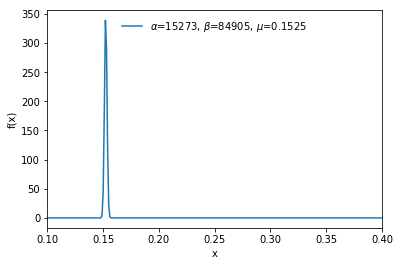

In [210]:
alpha = df_style['customers'].median() * df_style['style_percent'].mean()
beta = df_style['customers'].median() * (1-df_style['style_percent'].mean())

plot_beta(alpha, beta, [0.1,.4])

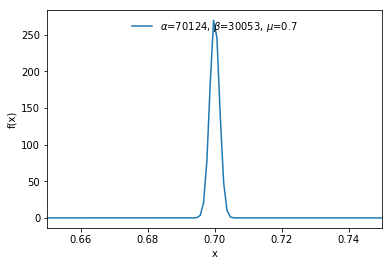

In [211]:
warehouse_split = 0.70
warehouse_demand_east_coast = df_style['customers'].median() * warehouse_split
warehouse_demand_west_coast = df_style['customers'].median() * (1-warehouse_split)

plot_beta(warehouse_demand_east_coast, warehouse_demand_west_coast, [0.65,0.75])

In [212]:
df_style['style_percent'].mean()

0.15246101631870665

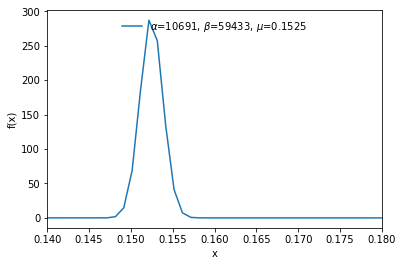

In [213]:
style_alpha = df_style['customers'].median() * df_style['style_percent'].mean() * warehouse_split
style_beta = df_style['customers'].median() * (1-df_style['style_percent'].mean()) * warehouse_split
plot_beta(style_alpha, style_beta, xlim=[0.14, 0.18])

In [214]:
with pm.Model() as style_model:

    # Style Priors:
    # we'll model the style distribution as a beta prior
    customers = pm.Poisson('customers', mu=df_style['customers'].median())
    
    east_coast_probability_prior = pm.Beta('east_coast_probability', 
                                           alpha=warehouse_demand_east_coast, 
                                           beta=warehouse_demand_west_coast, 
                                           testval=warehouse_split)
    
    east_coast_demand = pm.Binomial('east_coast_demand', 
                                        n=customers, 
                                        p=east_coast_probability_prior)
    
    
    style_probability_prior = pm.Beta('style_probability', alpha=style_alpha, beta=style_beta, testval=df_style['style_percent'].mean())
    
    
    style_likelihood = pm.Binomial('style_likelihood', n=east_coast_demand, p=style_probability_prior, observed=df_style['style_demand'] * warehouse_split)
    

In [215]:
n_samples, n_burn = 10000, 5000
with style_model:
    style_trace = pm.sample(n_samples, tune=n_burn, random_seed=42, progressbar=True)    

Assigned Metropolis to customers
Assigned NUTS to east_coast_probability_logodds__
Assigned Metropolis to east_coast_demand
Assigned NUTS to style_probability_logodds__
100%|█████████▉| 14968/15000 [00:34<00:00, 439.10it/s]/Users/claus/anaconda3/lib/python3.6/site-packages/pymc3/step_methods/hmc/nuts.py:451: UserWarning: The acceptance probability in chain 0 does not match the target. It is 0.710845958616, but should be close to 0.8. Try to increase the number of tuning steps.
  % (self._chain_id, mean_accept, target_accept))
100%|██████████| 15000/15000 [00:34<00:00, 439.24it/s]


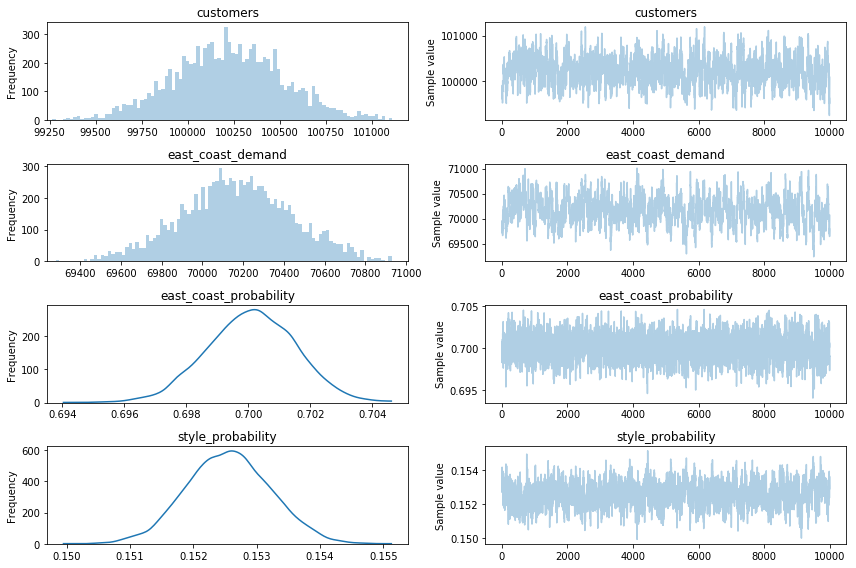

In [216]:
pm.traceplot(style_trace);

In [217]:
with style_model:
    style_ppc = pm.sample_ppc(style_trace)

100%|██████████| 10000/10000 [00:01<00:00, 6591.32it/s]


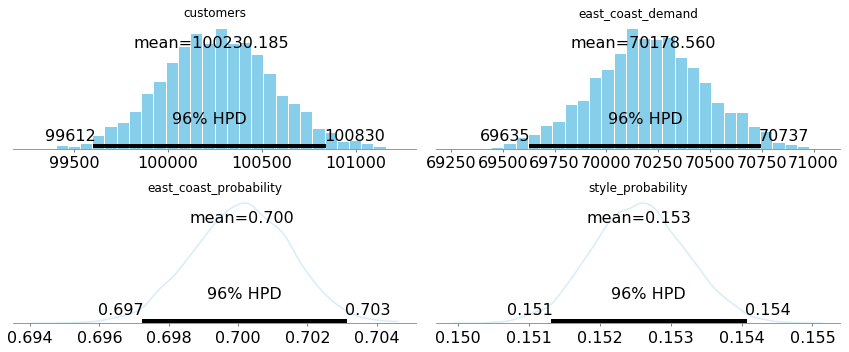

In [218]:
pm.plot_posterior(style_trace, color='#87ceeb', kde_plot=True, alpha_level=0.04);

In [219]:
style_ppc

{'style_likelihood': array([10585, 10740, 10683, ..., 10789, 10775, 10768])}

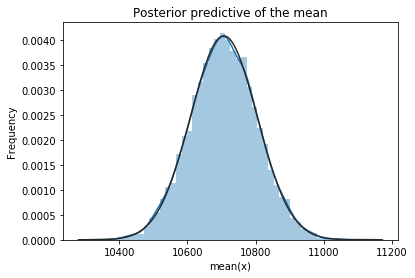

In [220]:
ax = plt.subplot()
sns.distplot([n for n in style_ppc['style_likelihood']], kde=True, ax=ax, fit=stats.norm)
# ax.axvline(np.int(df_style['style_demand'].mean()), color='r', linestyle='dashed')
ax.set(title='Posterior predictive of the mean', xlabel='mean(x)', ylabel='Frequency');

In [221]:
skus = ['34_L_S', '36_S_S', '38_S_S', '40_R_S', '44_R_S', '56_S_S']
len(skus)

6

```
product_style_category_name	sku	sku_size	sku_length	sku_fit	sku_perc
product_style_code						
CT001	Jackets	34_L_S	34	L	S	0.000555
CT001	Jackets	36_S_S	36	S	S	0.041745
CT001	Jackets	38_S_S	38	S	S	0.071068
CT001	Jackets	40_R_S	40	R	S	0.152071
CT001	Jackets	44_R_S	44	R	S	0.072508
CT001	Jackets	56_S_S	56	S	S	0.000312
```

In [222]:
size_distribution = [0.00555, 0.041745, 0.071068, 0.152071, 0.072508, 0.00312]

In [223]:
df_style['style_demand'].values[0]

15496

In [224]:
df_size_distribution = pd.DataFrame(size_distribution, columns=['size_distribution'], index=skus)
df_size_distribution

,size_distribution
34_L_S,0.005550
36_S_S,0.041745
38_S_S,0.071068
40_R_S,0.152071
44_R_S,0.072508
56_S_S,0.003120


In [225]:
# df_size_distribution.join(df_style)
df_sizes = pd.DataFrame((df_style['style_demand'].values.reshape(12,1) @ df_size_distribution['size_distribution'].values.T.reshape(1,6)).astype(int), columns=skus)
df_sizes

,34_L_S,36_S_S,38_S_S,40_R_S,44_R_S,56_S_S
0,86,646,1101,2356,1123,48
1,82,620,1056,2259,1077,46
2,86,653,1112,2379,1134,48
3,91,689,1174,2512,1198,51
4,81,616,1049,2245,1070,46
5,81,616,1049,2245,1070,46
6,92,692,1178,2521,1202,51
7,87,658,1120,2397,1143,49
8,80,606,1032,2209,1053,45
9,86,648,1104,2363,1126,48


In [226]:
df_sizes = df_sizes.melt(var_name='sku', value_name='size_demand')#.set_index('sku')

In [227]:
df_size_demand = df_sizes.groupby('sku').median()['size_demand']
df_size_demand

sku
34_L_S      84.0
36_S_S     633.0
38_S_S    1078.5
40_R_S    2307.5
44_R_S    1100.0
56_S_S      47.0
Name: size_demand, dtype: float64

In [228]:
n_samples, n_burn = 10000, 5000

In [229]:
df_style['style_percent']

0     0.154195
1     0.148817
2     0.155464
3     0.162751
4     0.147998
5     0.147998
6     0.163213
7     0.156470
8     0.145986
9     0.154582
10    0.146038
11    0.146020
Name: style_percent, dtype: float64

In [230]:
np.round(df_size_demand * warehouse_split, 0)

sku
34_L_S      59.0
36_S_S     443.0
38_S_S     755.0
40_R_S    1615.0
44_R_S     770.0
56_S_S      33.0
Name: size_demand, dtype: float64

In [233]:
with pm.Model() as sku_model:

    # Style Priors:
    # we'll model the style distribution as a beta prior
    customers = pm.Poisson('customers', mu=df_style['customers'].median())
    
    east_coast_probability_prior = pm.Beta('east_coast_probability', 
                                           alpha=warehouse_demand_east_coast, 
                                           beta=warehouse_demand_west_coast, 
                                           testval=warehouse_split)
    
    east_coast_demand = pm.Binomial('east_coast_demand', 
                                        n=customers, 
                                        p=east_coast_probability_prior)
    
    
    style_probability_prior = pm.Beta('style_probability', alpha=style_alpha, beta=style_beta, testval=df_style['style_percent'].mean())
    
    
    style_likelihood = pm.Binomial('style_likelihood', n=east_coast_demand, p=style_probability_prior)
    
    style_demand_prior = pm.Deterministic('style_demand_prior', customers * east_coast_demand * style_probability_prior)
    
        
    size_probability_prior = pm.Beta('size_probability', 
                                     alpha=df_size_distribution['size_distribution'].values * style_alpha, 
                                     beta=df_size_distribution['size_distribution'].values * style_beta, 
                                     shape=len(skus))
    
#     size_demand_prior = pm.Deterministic('size_demand_prior', customers * style_probability_prior * size_probability_prior)
    
    size_planned = pm.Binomial('size_likelihood', n=style_likelihood, p=size_probability_prior, observed=np.round(df_size_demand * warehouse_split, 0))

In [234]:
with sku_model:
    sku_trace = pm.sample(n_samples, tune=n_burn, random_seed=42, progressbar=True)    

Assigned Metropolis to customers
Assigned NUTS to east_coast_probability_logodds__
Assigned Metropolis to east_coast_demand
Assigned NUTS to style_probability_logodds__
Assigned Metropolis to style_likelihood
Assigned NUTS to size_probability_logodds__
100%|██████████| 15000/15000 [01:12<00:00, 207.84it/s]


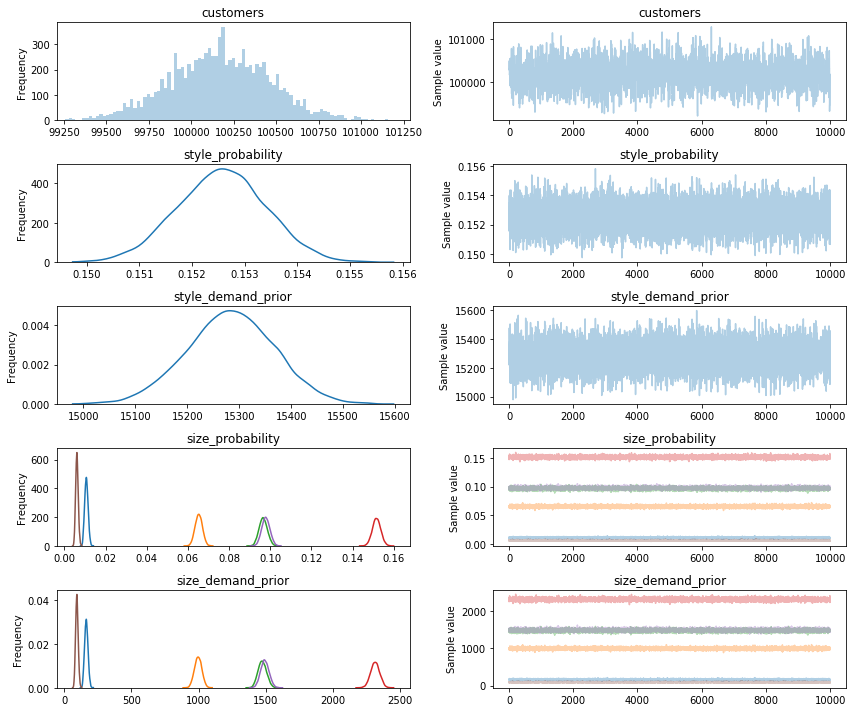

In [102]:
pm.traceplot(sku_trace);

In [103]:
pm.df_summary(sku_trace, alpha=0.04)

,mean,sd,mc_error,hpd_2,hpd_98
customers,100176.957300,297.701325,6.863723,99572.000000,100807.000000
style_probability,0.152567,0.000841,0.000009,0.150799,0.154250
style_demand_prior,15283.662681,84.037813,0.727660,15110.772645,15454.959501
size_probability__0,0.010644,0.000820,0.000007,0.008960,0.012265
size_probability__1,0.065256,0.001753,0.000016,0.061723,0.068840
size_probability__2,0.096547,0.002003,0.000015,0.092538,0.100600
size_probability__3,0.151639,0.002041,0.000017,0.147455,0.155855
size_probability__4,0.097828,0.001964,0.000017,0.093909,0.101863
size_probability__5,0.006067,0.000617,0.000005,0.004818,0.007341
size_demand_prior__0,162.670721,12.551351,0.108121,137.808970,188.522832


In [104]:
with sku_model:
    sku_ppc = pm.sample_ppc(sku_trace)

100%|██████████| 10000/10000 [00:04<00:00, 2261.05it/s]


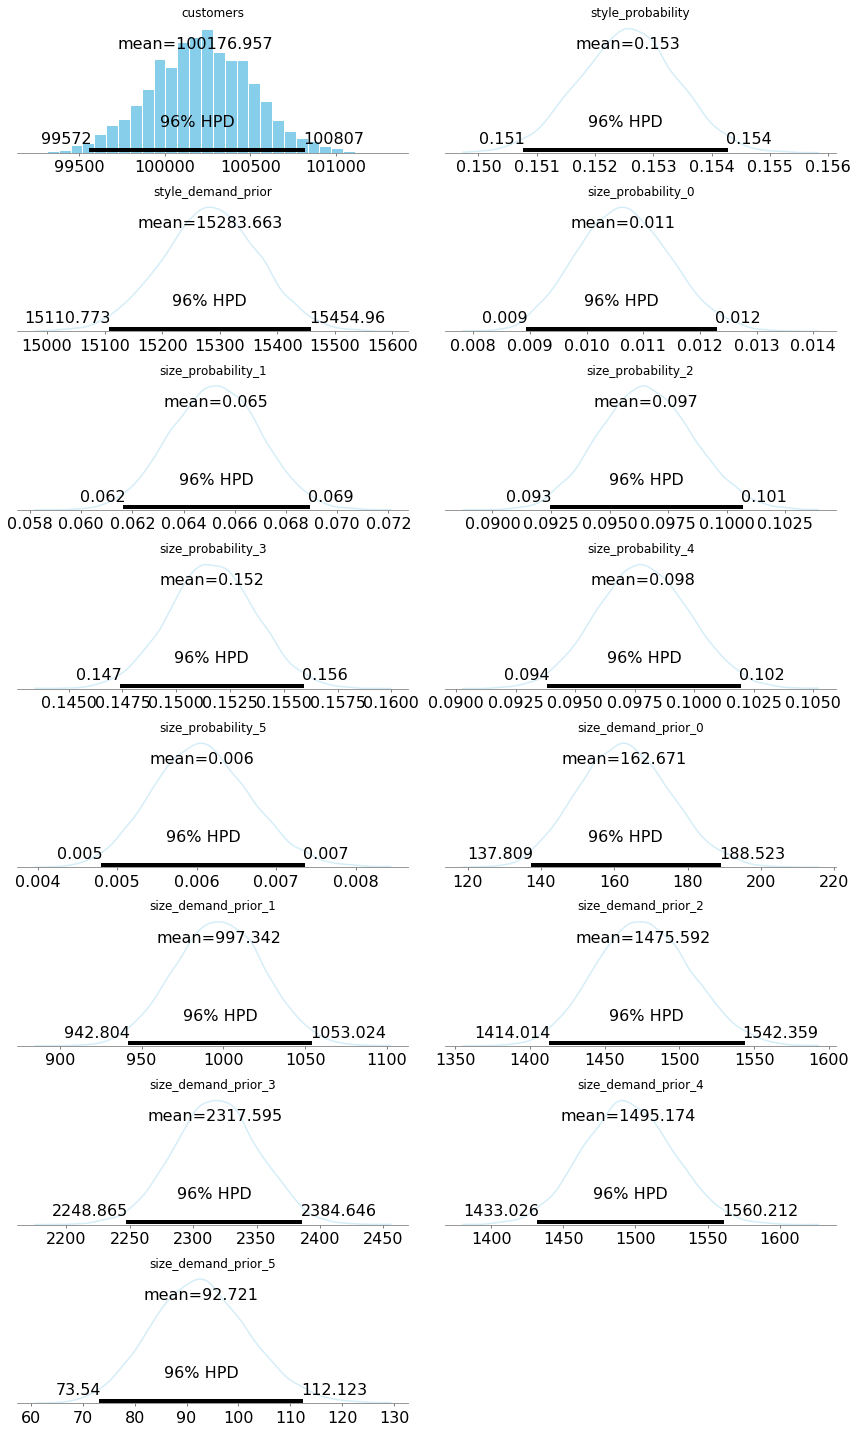

In [105]:
pm.plot_posterior(sku_trace, kde_plot=True, color='#87ceeb', alpha_level=0.04);

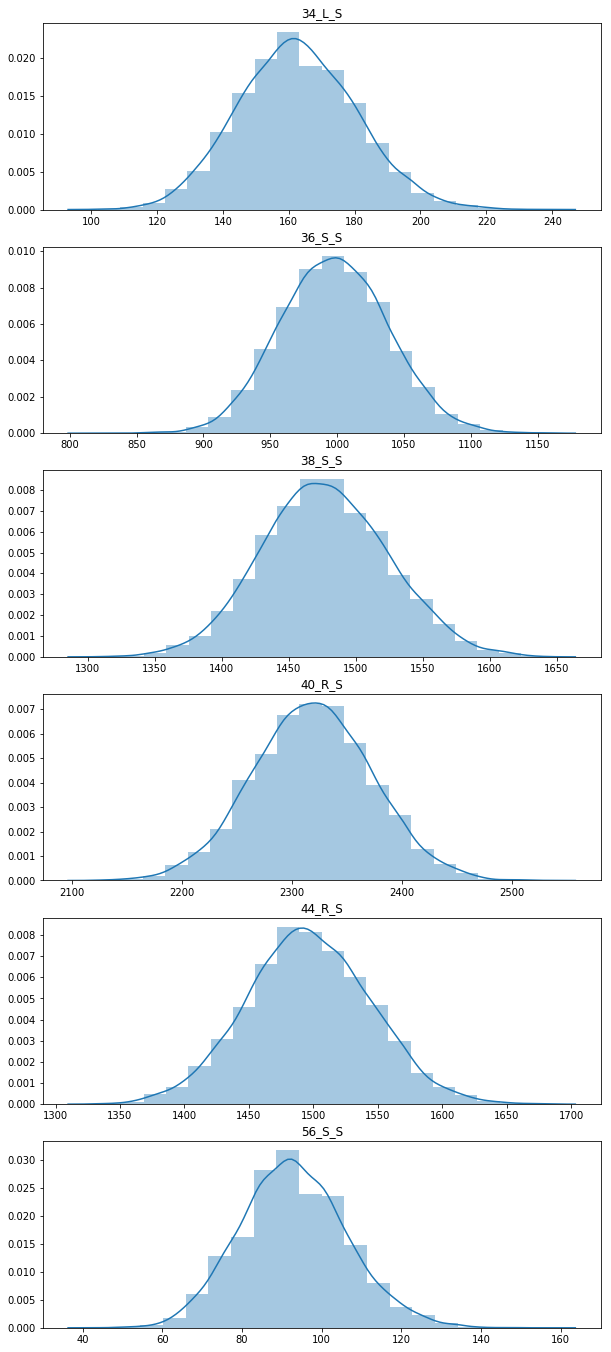

In [149]:
f, ax = plt.subplots(len(skus), 1, figsize=(10, len(skus)*4))

for i, sku in enumerate(skus):
    sns.distplot([ppc[i] for ppc in sku_ppc['size_likelihood']], kde=True, ax=ax[i], bins=20)
# ax.axvline(np.int(df_style['style_demand'].median()), color='r', linestyle='dashed')
    ax[i].set(title=f'{sku}');

In [148]:
pm.hpd(sku_ppc['size_likelihood'], alpha=0.04)

array([[  127.,   199.],
       [  912.,  1075.],
       [ 1383.,  1575.],
       [ 2211.,  2434.],
       [ 1394.,  1593.],
       [   64.,   119.]])

In [150]:
pm.quantiles(sku_ppc['size_likelihood'], qlist=[98])

{98: array([ 200, 1081, 1576, 2431, 1598,  122])}